<a href="https://www.kaggle.com/code/yeemeitsang/cnn-cat-vs-dog?scriptVersionId=128693581" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

**Introduction**

This is a CNN model designed to differentiate between images of cats and dogs using the Kaggle cat vs dog dataset. 

The model is trained without a pretrained base layer and utilizes a simple helper function to extract image and label data from the dataset directory. 

For those interested in incorporating a state-of-the-art pretrained model, MobileNetV2, and performing image augmentation to improve prediction accuracy, [my GitHub repo](https://github.com/a-t-em/Binary-Image-Classification-Cat-Dog) provides a detailed implementation.

In [1]:
#import libraries
import numpy as np
import pandas as pd
import os, cv2, glob
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense 

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


**Extract and preprocess data**

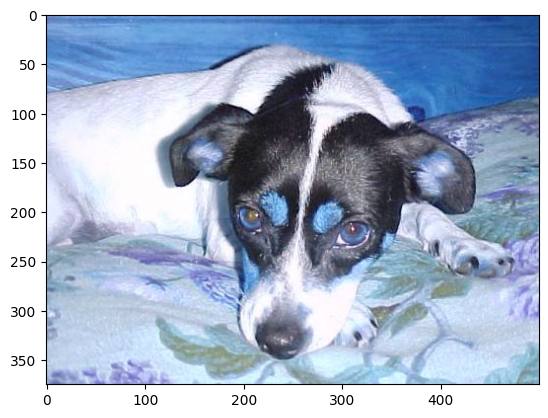

In [2]:
#copy directory path 
directory_path = "/kaggle/input/kaggle-cat-vs-dog-dataset/kagglecatsanddogs_3367a/PetImages/"
#view a single image
img = cv2.imread(directory_path + '/Dog/7981.jpg')
plt.imshow(img)

In [3]:
images = []
labels = []
size = (40, 40)

cat_folder = directory_path + 'Cat/'
dog_folder = directory_path + 'Dog/'

#helper function to extract image and label data 
def getData(folder, label):
    file_names = os.listdir(folder)

    for file_name in file_names:
        path = folder + file_name
        #read image data
        img = cv2.imread(path)
        if img is not None:
            #resize image to save space
            img = cv2.resize(img, dsize=size)
            images.append(img)
            labels.append(label)

getData(cat_folder, 0)
getData(dog_folder, 1)

len(images), len(labels)

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 254 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2230 extraneous bytes before marker 0xd9
Corrupt JPEG data: 399 extraneous bytes before marker 0xd9


(24913, 24913)

In [4]:
#split into train and test data
train_feature, test_feature, train_label, test_label = \
    train_test_split(images, labels, test_size=0.2)
len(train_feature), len(train_label)

(19930, 19930)

In [5]:
#convert into numpy arrays
train_feature = np.array(train_feature)
test_feature = np.array(test_feature)
train_label = np.array(train_label)
test_label = np.array(test_label)
test_feature.shape, test_label.shape

((4983, 40, 40, 3), (4983,))

In [6]:
#optional: save data for future use
path = '/kaggle/working/'
np.save(path + 'train_feature.npy', train_feature)
np.save(path + 'test_feature.npy', test_feature)
np.save(path + 'train_label.npy', train_label)
np.save(path + 'test_label.npy', test_label)
#example usage
#train_feature = np.load('/kaggle/working/train_feature.npy')

In [7]:
#format features into right shape for CNN
train_feature_vector = train_feature.reshape(len(train_feature), 40, 40, 3).astype('float32')
test_feature_vector = test_feature.reshape(len(test_feature), 40, 40, 3).astype('float32')
train_feature_vector.shape, test_feature_vector.shape

((19930, 40, 40, 3), (4983, 40, 40, 3))

In [8]:
#normalize data
train_feature_normalize = train_feature_vector/255
test_feature_normalize = test_feature_vector/255

In [9]:
#one hot encode targets 
train_label_onehot = np_utils.to_categorical(train_label)
test_label_onehot = np_utils.to_categorical(test_label)
train_label_onehot[:5]

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

**Build and train model**

In [10]:
model = Sequential()
model.add(Conv2D(filters=10, kernel_size=(5, 5), padding='same', \
                 input_shape=(40, 40, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(filters=20, kernel_size=(5, 5), padding='same', \
                 input_shape=(40, 40, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(2, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 40, 40, 10)        760       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 20, 20, 10)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 20, 20, 10)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 20, 20, 20)        5020      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 10, 20)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 10, 10, 20)        0

In [11]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#save fitting data into variable for graph plotting
history = model.fit(train_feature_normalize, train_label_onehot, validation_split=0.2, \
                   epochs=12, batch_size=200, verbose=2)

Epoch 1/12


2023-05-07 23:51:19.207505: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


80/80 - 11s - loss: 0.7274 - accuracy: 0.5364 - val_loss: 0.6743 - val_accuracy: 0.5805 - 11s/epoch - 135ms/step
Epoch 2/12
80/80 - 1s - loss: 0.6624 - accuracy: 0.6010 - val_loss: 0.6576 - val_accuracy: 0.5981 - 688ms/epoch - 9ms/step
Epoch 3/12
80/80 - 1s - loss: 0.6325 - accuracy: 0.6396 - val_loss: 0.6230 - val_accuracy: 0.6445 - 688ms/epoch - 9ms/step
Epoch 4/12
80/80 - 1s - loss: 0.6117 - accuracy: 0.6624 - val_loss: 0.5946 - val_accuracy: 0.6726 - 746ms/epoch - 9ms/step
Epoch 5/12
80/80 - 1s - loss: 0.5789 - accuracy: 0.6941 - val_loss: 0.5913 - val_accuracy: 0.6734 - 696ms/epoch - 9ms/step
Epoch 6/12
80/80 - 1s - loss: 0.5596 - accuracy: 0.7080 - val_loss: 0.5502 - val_accuracy: 0.7142 - 697ms/epoch - 9ms/step
Epoch 7/12
80/80 - 1s - loss: 0.5431 - accuracy: 0.7270 - val_loss: 0.5357 - val_accuracy: 0.7258 - 703ms/epoch - 9ms/step
Epoch 8/12
80/80 - 1s - loss: 0.5230 - accuracy: 0.7425 - val_loss: 0.5322 - val_accuracy: 0.7273 - 701ms/epoch - 9ms/step
Epoch 9/12
80/80 - 1s - lo

**Make predictions and evaluate model**

In [12]:
#evaluate model on test dataset
scores = model.evaluate(test_feature_normalize, test_label_onehot)
scores

156/156 [==============================] - 1s 3ms/step - loss: 0.4770 - accuracy: 0.7819


[0.4770136773586273, 0.7818583250045776]

In [13]:
#make predictions
prediction = model.predict(test_feature_normalize)
prediction = np.argmax(prediction, axis=1)
prediction[:5]

156/156 [==============================] - 0s 2ms/step


array([0, 0, 0, 1, 0])

In [14]:
#compare to test labels
test_label[:5]

array([0, 0, 0, 1, 0])

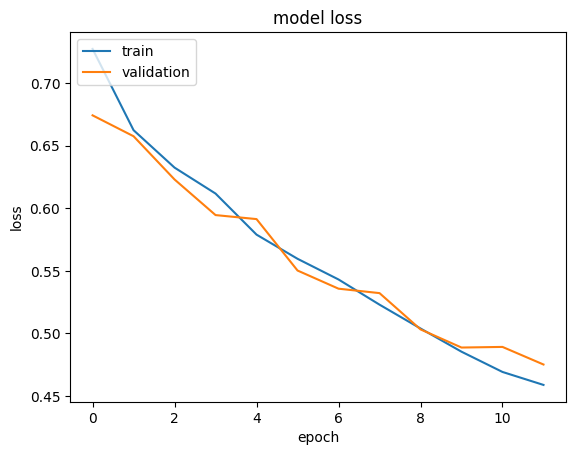

In [15]:
#plot loss curves
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

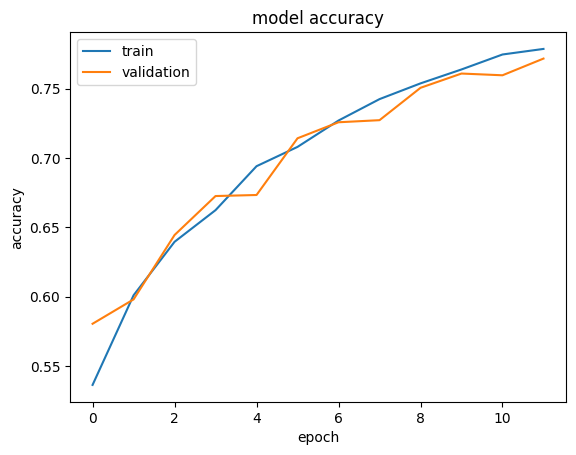

In [16]:
#plot accuracy curves
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()